# Simple Boston Demo

The ability to use hierarchical feature clusterings to control  PartitionExplainer is still in an Alpha state, but this notebook demonstrates how to use it right now. Note that I am releasing this to get feedback and show how I am working to address concerns about the speed of our model agnostic approaches and the impact of feature correlations. This is all as-yet unpublished work, so treat it accordingly.

When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

In [1]:
import numpy as np
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
import xgboost
import shap
import pandas as pd

## Train the model

In [2]:
X,y = shap.datasets.boston()
#X = X.iloc[:,:4]
model = xgboost.XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

x = X.values[0:1,:]
refs = X.values[1:100] # use 100 samples for our background references (using the whole dataset would be slower)

## Compute a hierarchal clustering of the input features

In [3]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

In [4]:
cluster_matrix = shap.partition_tree(X)

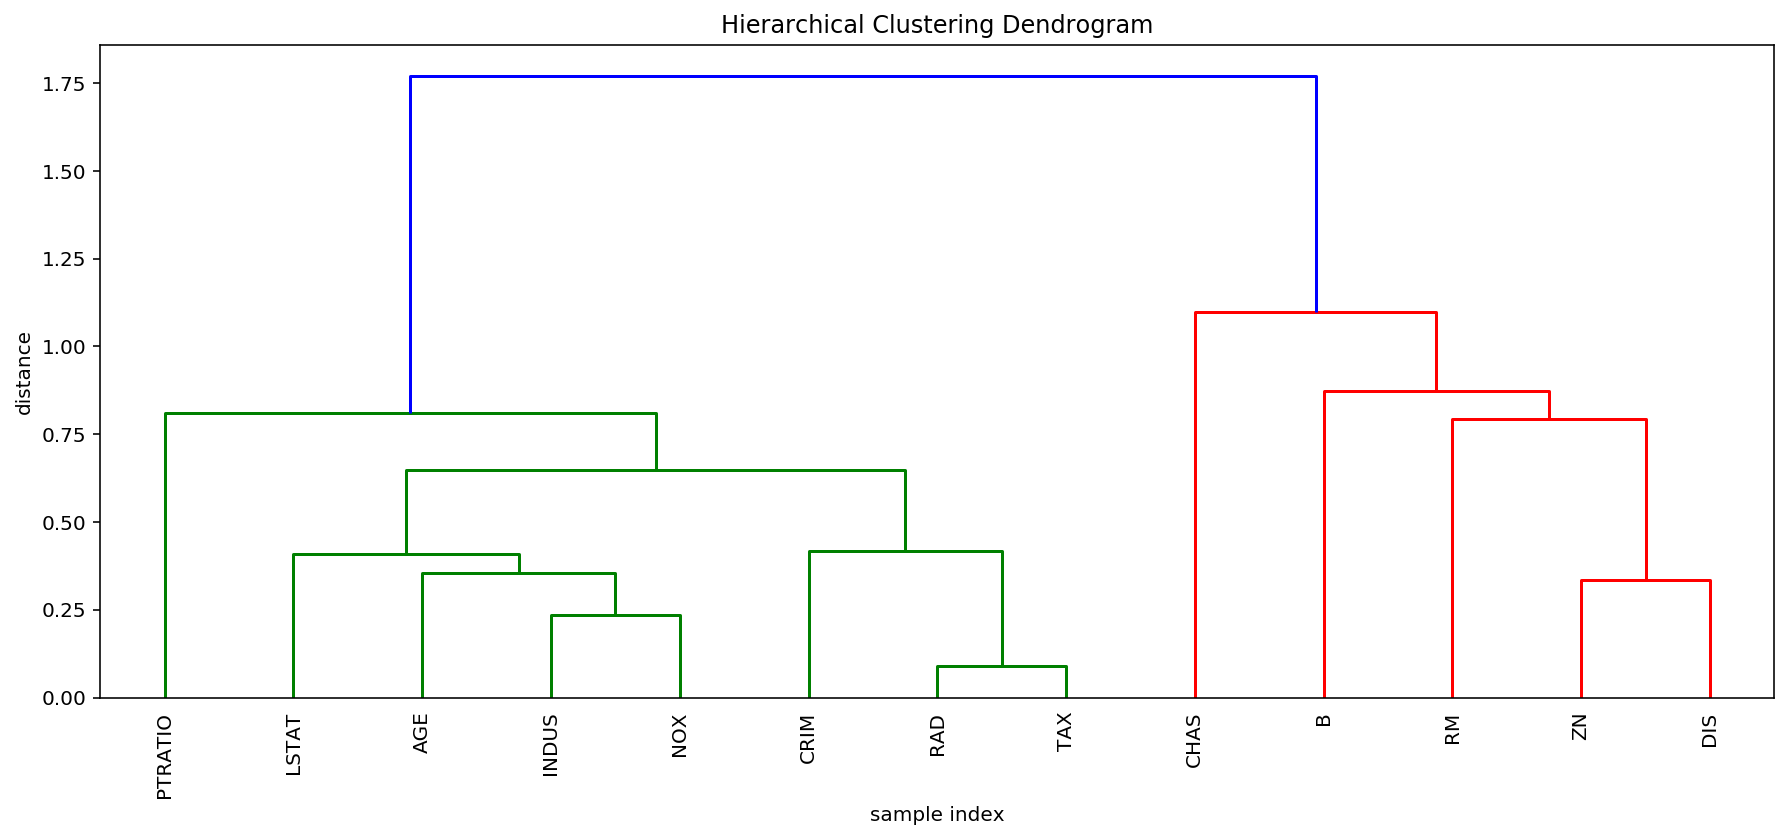

In [5]:
# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

In [6]:
shap.common.shapley_coefficients(12)

array([0.08333333, 0.00757576, 0.00151515, 0.00050505, 0.00025253,
       0.00018038, 0.00018038, 0.00025253, 0.00050505, 0.00151515,
       0.00757576, 0.08333333])

## Explain the first sample with Partition Explainer

In [7]:
# define the model as a python function 
f = lambda x: model.predict(x, output_margin=True, validate_features=False)

# explain the model
# pexplainer = shap.PartitionExplainer(f, refs, cluster_matrix)
# shap_values = pexplainer(x, npartitions=500)

m = shap.maskers.Tabular(refs, hclustering="correlation")
pexplainer = shap.explainers.BruteForce(f, refs)
p2explainer = shap.explainers.Partition(f, m)


explainers.Partition is still in an alpha state, so use with caution...


In [8]:
import sys

In [12]:
shap_values = pexplainer(x, max_evals=5000)
shap_values2 = p2explainer(x, max_evals=50000)

## Compare with TreeExplainer

In [13]:
texplainer = shap.TreeExplainer(model, refs)
tshap_values = texplainer(x)

[<matplotlib.lines.Line2D at 0x7f2766d18250>]

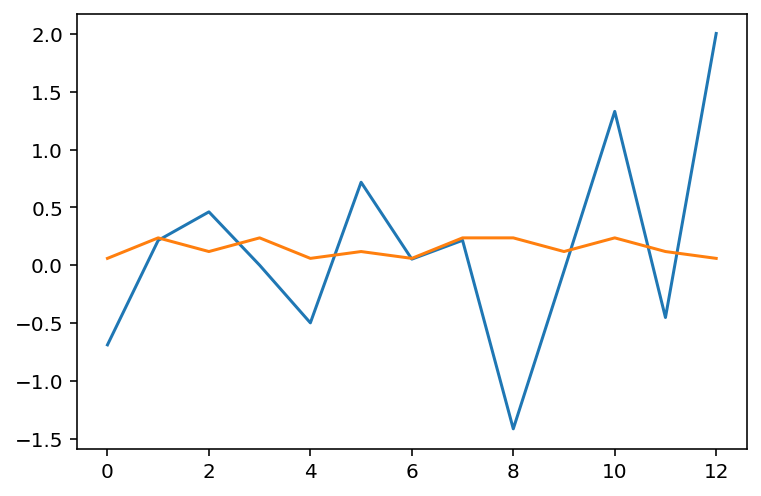

In [14]:
pl.plot(shap_values.values[0])
pl.plot(shap_values2.values[0])
#pl.plot(tshap_values.values[0])

In [27]:
nexplainer = shap.PermutationExplainer(f, refs)


In [108]:
shap_values3 = nexplainer(x, npermutations=10)

In [ ]:
batch_size = 10
data = X
batch = np.zeros((batch_size,) + data.shape[1:])
batch_index = 0
for i in range(npermutations):
    

In [29]:
n_sizes = 4
svals = np.zeros((n_sizes, X.shape[1]))
pvals = np.zeros((n_sizes, X.shape[1]))
nvals = np.zeros((n_sizes, X.shape[1]))
sizes = np.linspace(100, 500000, n_sizes)
for i,s in enumerate(sizes):
    s = int(s)
    s -= s % 2
    pvals[i] = pexplainer(x, nsamples=s).values[0]
    svals[i] = sexplainer(x, nsamples=s).values[0]
    nvals[i] = nexplainer(x, npermutations=s).values[0]

TypeError: __call__() got an unexpected keyword argument 'nsamples'

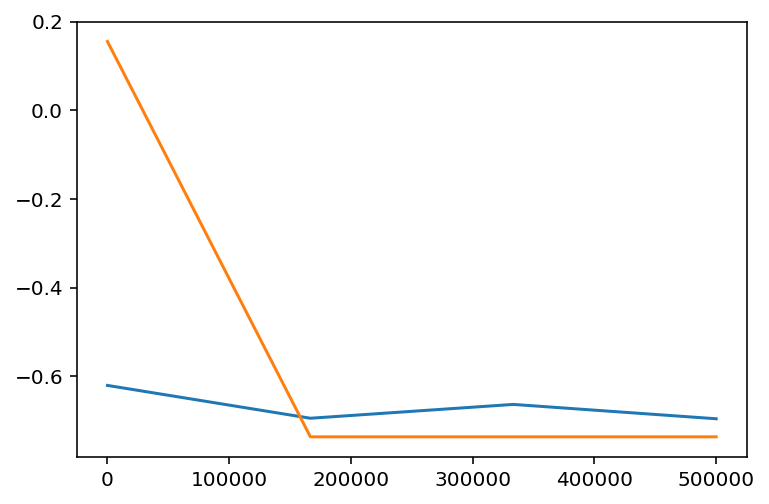

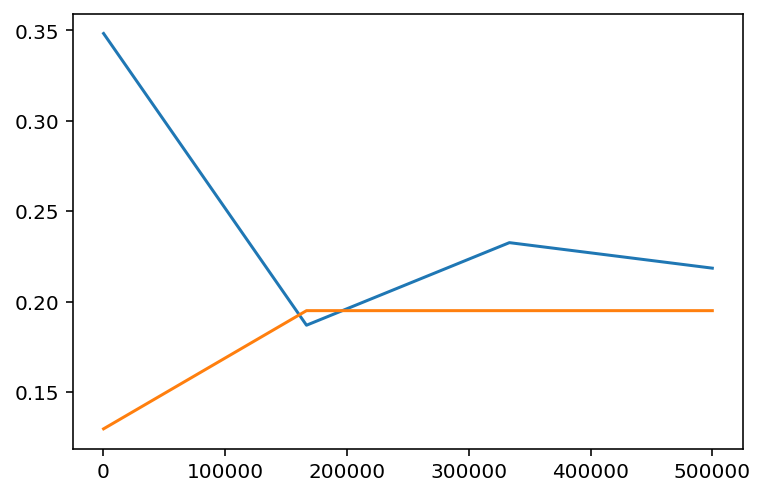

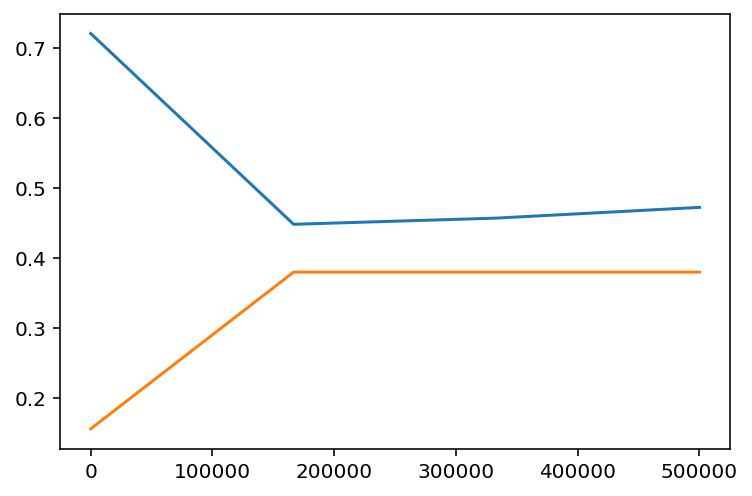

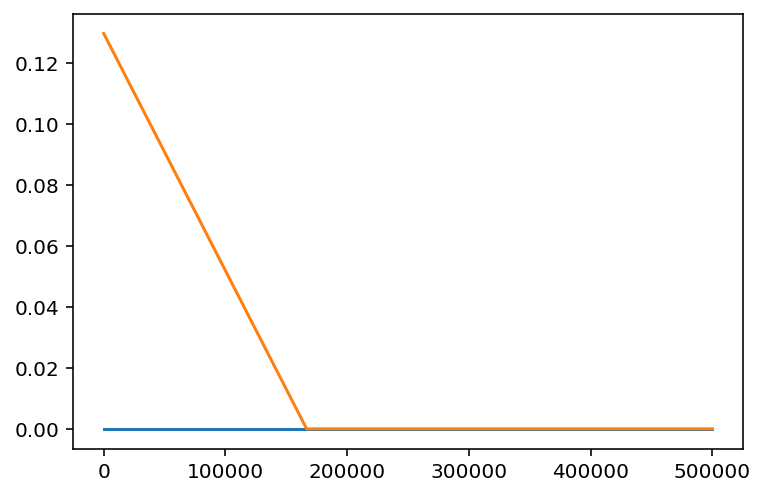

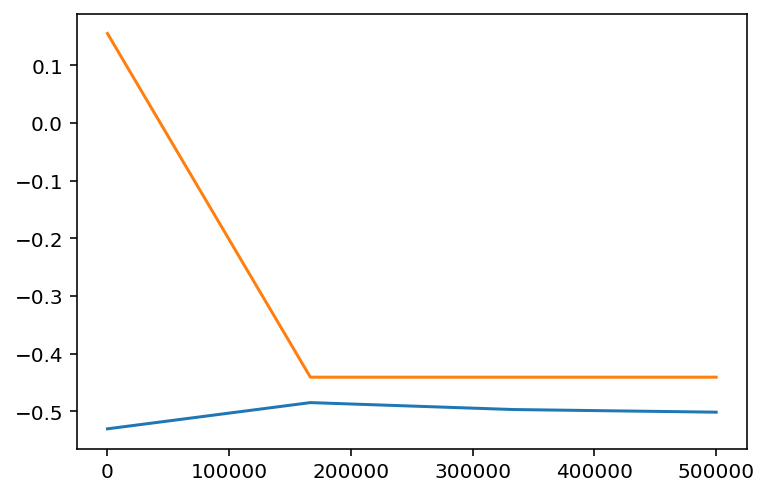

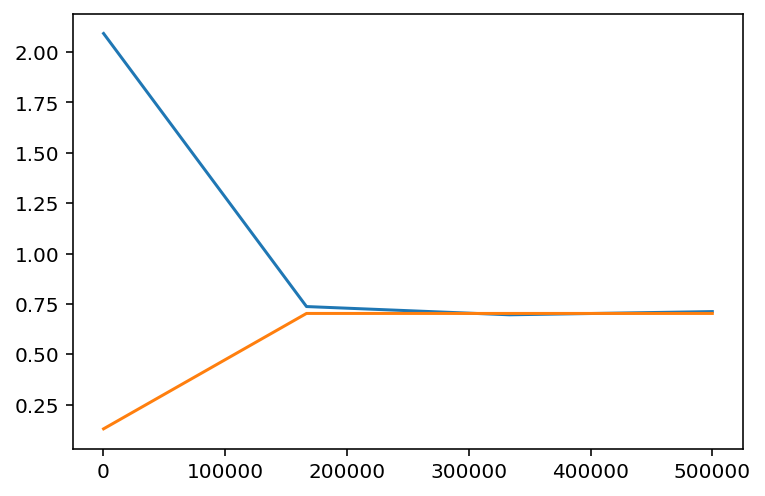

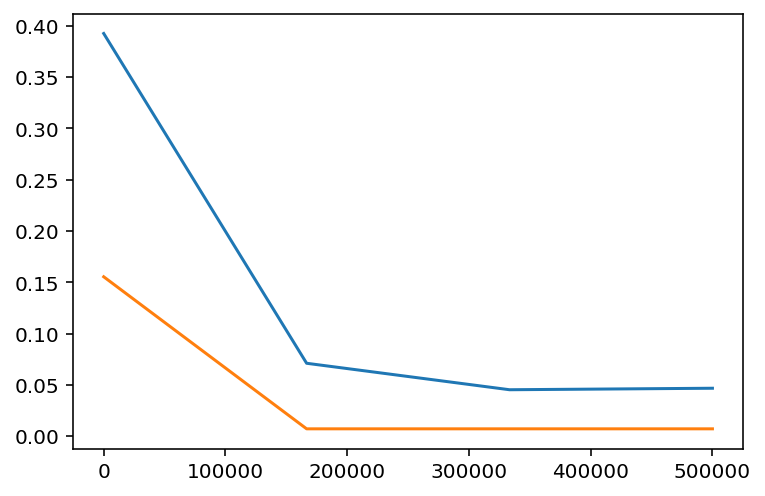

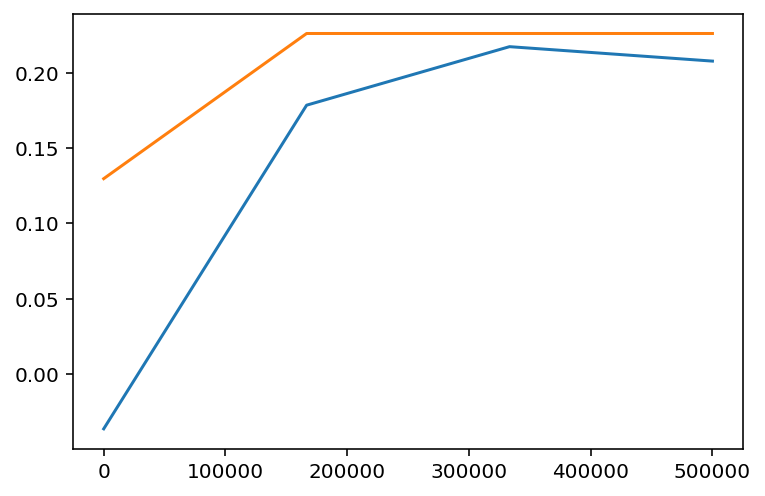

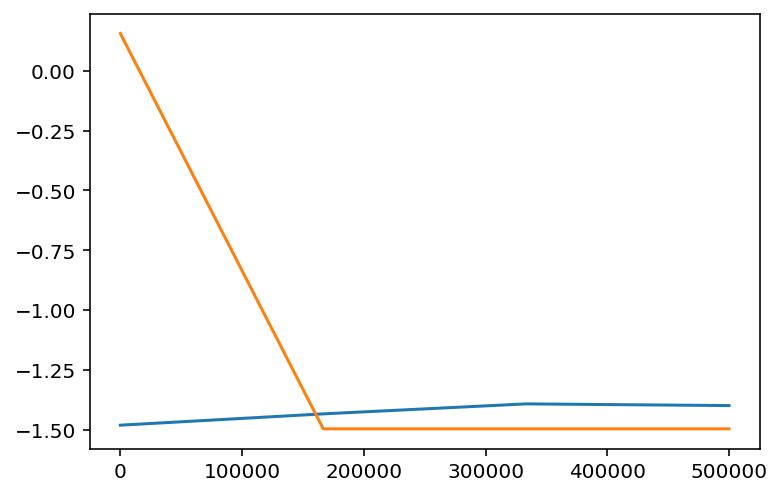

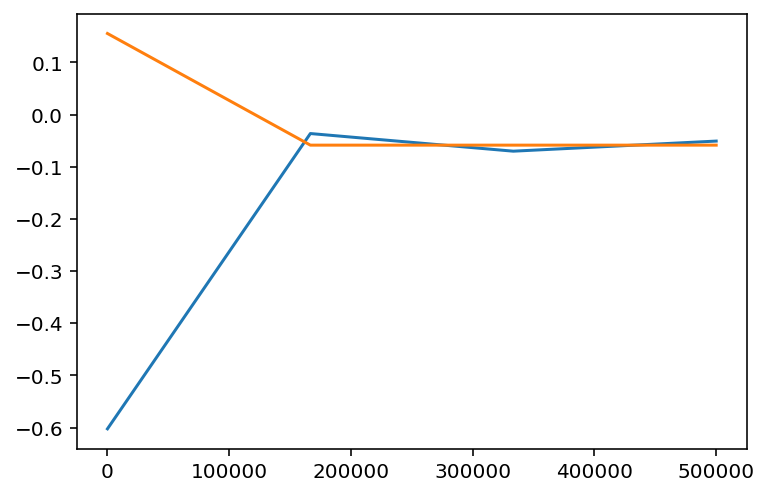

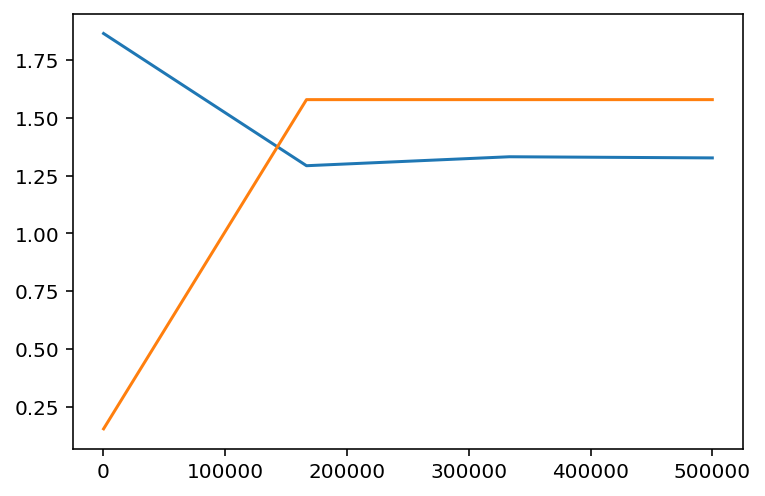

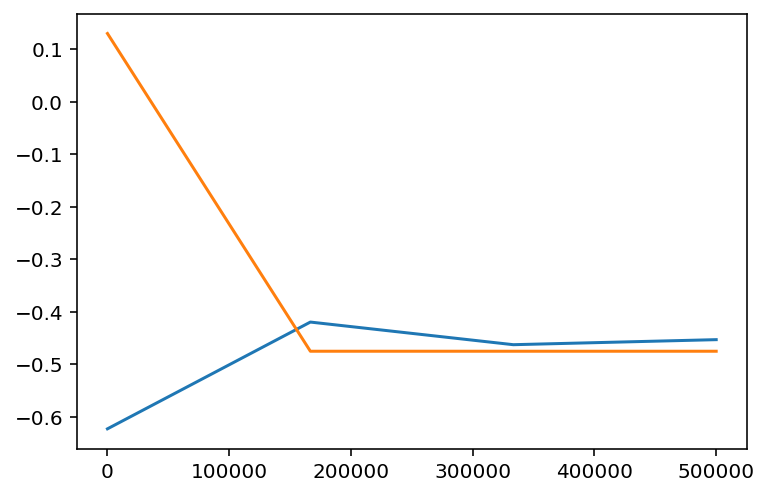

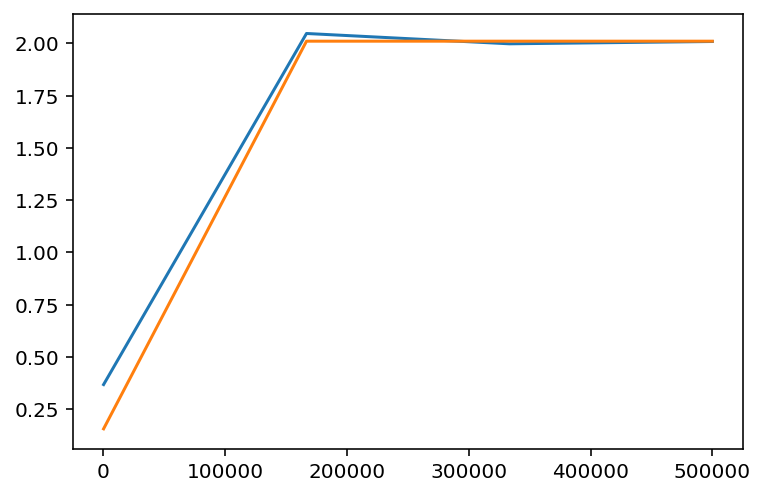

In [103]:
for i in range(svals.shape[1]):
    pl.plot(sizes, svals[:,i].T)
    pl.plot(sizes, pvals[:,i].T)
    pl.show()

[<matplotlib.lines.Line2D at 0x7f7d4c280750>]

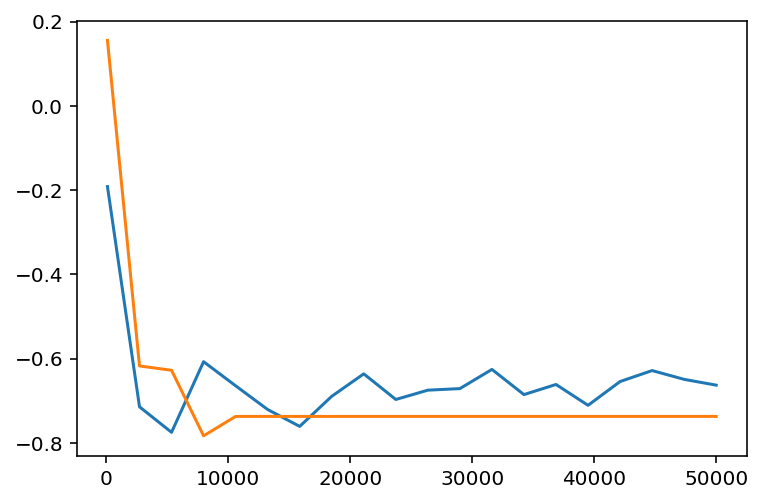

In [99]:
pl.plot(sizes, svals[:,0].T)
pl.plot(sizes, pvals[:,0].T)

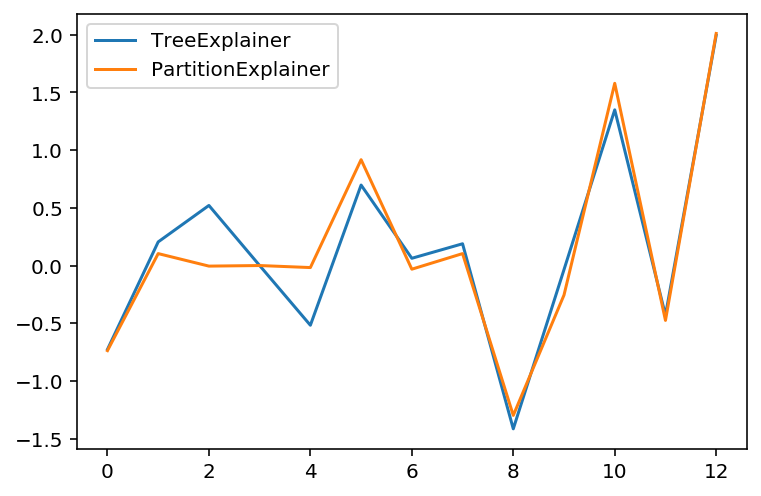

In [69]:
pl.plot(shap_values2.values[0], label="TreeExplainer")
pl.plot(shap_values.values[0], label="PartitionExplainer")
pl.legend()